In [1]:
from functions import *

In [2]:
cur_file = FILE_SENSORS_DATA_EST_PARAMS
df = pd.read_csv(cur_file)

In [3]:
x_format = None
TIME_MINS = 0
DATE_TIME = 1
TIME_IDX  = TIME_MINS

In [4]:
FLUX_COL = 'flux at 20° [L/m^2h]' #'flux [L/m^2h]'
FLUX_USED = FLUX_COL[:-9]
FLUX_MIN_COL = f'{FLUX_USED} min [L/m^2h]'
print(FLUX_USED)

flux at 20°


In [5]:
coeff_flux_min   =      read_estimated_coefficients_from_json(FILE_EST_COEFFS, 'flux min')
coeff_flux_slope =      read_estimated_coefficients_from_json(FILE_EST_COEFFS, 'flux slope')
coeff_res_tot_initial = read_estimated_coefficients_from_json(FILE_EST_COEFFS, 'res tot [1/m]') 
coeff_prs_permeate =    read_estimated_coefficients_from_json(FILE_EST_COEFFS, 'prs permeate [kPa]') 

In [6]:
PRS_PERMEATE_EST = coeff_prs_permeate['intercept'] # constant value 
INITIAL_VISCOSITY = calc_viscosity(20, pressure_Pa=(101325+PRS_PERMEATE_EST), element='Water')
INITIAL_RESISTANCE = np.nan
if coeff_res_tot_initial['x'] == ['viscosity permeate [Pa s]'] :
    INITIAL_RESISTANCE = coeff_res_tot_initial['intercept'] + coeff_res_tot_initial['coefficients'][0] * INITIAL_VISCOSITY
else :
    print("ERROR: UPDATE INITIAL RESISTANCE FORMULA!")

In [7]:
INITIAL_ADDED = True
if INITIAL_ADDED :
    df = add_initial_flux(df, INITIAL_VISCOSITY)

Note: for file_idx:2, tmp_idx:0, which is the first series after the clear water, the initial resistance a t=0 is estimated with:
total_resistance = a + b * log(1+time), using as training dataset the following 5 resistances recorded with time t=[1,5] [m].
Then, res_tot at t=0 is set equal to the intercept a=3.280E+12


In [8]:
MAX_TIME = 50
df = df[(df['time [m]'] <= MAX_TIME)]

In [9]:
# remove clear water samples
df = df[df['initial feed concentration [g/L]'] > 0]

In [10]:
for c in ['flux at 20° [L/m^2h]', 'flux at 20° min [L/m^2h]', 'TMP est [kPa]', 'viscosity permeate [Pa s]', 'd/dt flux at 20°'] :
    df[c] = df.apply(lambda x : np.nan if x['time [m]'] == MAX_TIME else x[c], axis=1)

In [11]:
# FILTER ROWS
# df = df[(df['file_idx'] == 2)]
# df = df[(df['file_idx'] >= 0) & (df['file_idx'] <= 2)]
# we exclude the case tmp_idx=5 which is the case when the TMPP has been lowered to the minimum which will not be done in real applications
# normally the TMP is started low and increased trhough time until the membrane is so dirty that system must be stopped and membrane cleaned 
# df = df[df['tmp_idx'] < 5]
#df = df[(df['is flux steady'] == 0.0) | (df['is flux steady'].isna())]
df['is forecast'] = df['is forecast'].astype(float)

In [12]:
df = df.reset_index(drop=True)
df['index'] = range(0, len(df))
#df['1 / (time [m] + 1)'] = df['time [m]'].apply(lambda x : (1/(x+1)))
df['exp(-time) [m]']  = df['time [m]'].apply(lambda x : math.exp(-x))

In [13]:
# get the index of the first row of each setting
group_cols = ['file_idx', 'tmp_idx']
init_cond = list(df[group_cols].drop_duplicates().index)
df[[
    'index', 'file_idx', 'tmp_idx', 'date', 'time [m]',
    FLUX_COL, FLUX_MIN_COL, 'TMP est [kPa]',
    'viscosity permeate [Pa s]', 
    #'res tot est [%]', 'res tot est [1/m]', 'res tot est smooth [1/m]',
    #'retentate concentration est [g/L]',
    #'permeate concentration est [g/L]', 
]].loc[init_cond]

,index,file_idx,tmp_idx,date,time [m],flux at 20° [L/m^2h],flux at 20° min [L/m^2h],TMP est [kPa],viscosity permeate [Pa s]
0,0,2,0,2023-11-09,0.0,163.336648,120.701611,149.056304,0.000989
51,51,2,2,2023-11-09,0.0,157.932526,127.848726,188.666900,0.000960
102,102,2,3,2023-11-09,0.0,197.726237,148.308714,273.211327,0.000944
153,153,2,4,2023-11-09,0.0,213.449219,154.143469,356.312249,0.000923
204,204,2,5,2023-11-09,0.0,209.495826,160.247452,432.690988,0.000899
255,255,2,6,2023-11-09,0.0,61.034087,63.147816,148.875841,0.000883
306,306,3,0,2023-11-09,0.0,63.553816,61.009907,149.372126,0.000848
357,357,3,5,2023-11-09,0.0,60.489063,49.032697,148.108936,0.000803
408,408,4,4,2023-11-09,0.0,145.468943,116.953158,436.209891,0.000778
459,459,4,5,2023-11-09,0.0,42.382219,41.850457,149.958619,0.000762


In [14]:
# actually the correct result of the flux min is the one at time t=0, the following must be ignored
df = apply_coefficients(df, coeff_flux_min,         'flux min est [L/m^2h]')
df = apply_coefficients(df, coeff_flux_slope,       f'k(n=2) est')
#df = apply_coefficients(df, coeff_res_tot_initial,  'res tot initial est [1/m]')

In [15]:
# TODO
#def compute_total_resistance(df, res_init=INITIAL_RESISTANCE, k_n_col='k(n=2)', tmp_col='TMP est [kPa]', flux_col='flux at 20° [L/m^2h]', flux_min_col='flux at 20° min [L/m^2h]', viscosity_col='viscosity permeate [Pa s]') :
#    k_n = df[k_n_col].fillna(0.0)
#    cur_flux = df[flux_col] / 1000
#    df['cur_flux'] = cur_flux
#    dt_flux = - k_n * (cur_flux - df[flux_min_col]) / 1000
#    df['dt_flux'] = dt_flux
#    viscosity = df[viscosity_col] / (1000 * 3600)
#    dt_viscosity = 0.0
#    tmp = df[tmp_col]
#    res_col_exact = 'res tot exact'
#    dt_res_col_exact = 'dt res tot exact'
#    # non constant viscosity
#    df[dt_res_col_exact] = - (tmp / (viscosity * cur_flux)) * (dt_flux / cur_flux + dt_viscosity / viscosity)
#    df.loc[0, res_col_exact] = INITIAL_RESISTANCE
#    for i in range(1, len(df)) :
#        df.loc[i, 'flux new'] = df.loc[i-1, 'cur_flux'] + df.loc[i-1, 'dt_flux']
#        df.loc[i, res_col_exact] = df.loc[i-1, res_col_exact] + df.loc[i-1, dt_res_col_exact]
#    # simplified assuming constant viscosity
#    # return - (prs_TMP * dt_flux) / (v * cur_flux * cur_flux);

In [16]:
#compute_total_resistance(df)
#display(df[['res tot exact', 'dt res tot exact', 'k(n=2)', 'res tot est [1/m]', 'TMP est [kPa]', 'flux at 20° [L/m^2h]', 'cur_flux', 'dt_flux', 'flux at 20° min [L/m^2h]', 'viscosity permeate [Pa s]']][:60])

In [17]:
n = 2
flux_pred_lbl_0 = f'flux est with k(n={n})-0' #using time=0 to estimate flux_min
flux_pred_lbl_1 = f'flux est with k(n={n})-1' #using time=1 to estimate flux_min
# df[flux_pred_lbl] = 1000 * df['TMP est [kPa]'] / (INITIAL_RESISTANCE * (INITIAL_VISCOSITY / (1000 * 3600)) )
k_n_est = f'k(n={n}) est'
df[flux_pred_lbl_0] = np.nan
df[flux_pred_lbl_1] = np.nan
new_series = True
bef_flux = np.nan
for i in range(len(df)) :
    cur_time = df.loc[i, 'time [m]'].astype(int)
    if new_series :
        flux_min_pred_0 = df.loc[i,   f'flux min est [L/m^2h]']
        flux_min_pred_1 = df.loc[i+1, f'flux min est [L/m^2h]']
        flux_min_real   = df.loc[i, FLUX_MIN_COL]
        cur_flux        = df.loc[i, FLUX_COL]
        df.loc[i, flux_pred_lbl_0] = cur_flux
        df.loc[i, flux_pred_lbl_1] = cur_flux
        print("#########################################################################")
        print(f'## i: {i}, cur_time: {cur_time}, flux_min real: {flux_min_real:.3f}, min est t=0: {flux_min_pred_0:.3f}, min est t=1: {flux_min_pred_1:.3f}')
        print(f'i: {i:2d}, cur_time: {cur_time:2d}, flux_min real: {flux_min_real:.3f}, min est t=0: {flux_min_pred_0:.3f}, bef_flux: {bef_flux:.3f}, cur_flux: {cur_flux:.3f}')
        new_series = False
    elif pd.isna(df.loc[i, FLUX_COL]) :
        bef_flux = np.nan
        new_series = True
    else :
        k = df.loc[i, f'k(n=2) est']
        for (lbl, min_flux) in [(flux_pred_lbl_0, flux_min_pred_0), (flux_pred_lbl_1, flux_min_pred_1)] :
            bef_flux = df.loc[i-1, lbl]
            cur_flux = (bef_flux + k * min_flux) / (1+k)
            df.loc[i, lbl] = cur_flux
        print(f'i: {i:2d}, cur_time: {cur_time:2d}, flux_min real: {flux_min_real:.3f}, min est t=0: {flux_min_pred_0:.3f}, min est t=0: {flux_min_pred_1:.3f}, bef_flux: {bef_flux:.3f}, cur_flux_0: {df.loc[i, flux_pred_lbl_0]:.3f}, cur_flux_1: {df.loc[i, flux_pred_lbl_1]:.3f}, k: {k:.5f}')

#########################################################################
## i: 0, cur_time: 0, flux_min real: 120.702, min est t=0: 125.743, min est t=1: 115.100
i:  0, cur_time:  0, flux_min real: 120.702, min est t=0: 125.743, bef_flux: nan, cur_flux: 163.337
i:  1, cur_time:  1, flux_min real: 120.702, min est t=0: 125.743, min est t=0: 115.100, bef_flux: 163.337, cur_flux_0: 155.680, cur_flux_1: 153.512, k: 0.25577
i:  2, cur_time:  2, flux_min real: 120.702, min est t=0: 125.743, min est t=0: 115.100, bef_flux: 153.512, cur_flux_0: 151.288, cur_flux_1: 147.877, k: 0.17193
i:  3, cur_time:  3, flux_min real: 120.702, min est t=0: 125.743, min est t=0: 115.100, bef_flux: 147.877, cur_flux_0: 148.129, cur_flux_1: 143.824, k: 0.14109
i:  4, cur_time:  4, flux_min real: 120.702, min est t=0: 125.743, min est t=0: 115.100, bef_flux: 143.824, cur_flux_0: 145.559, cur_flux_1: 140.525, k: 0.12974
i:  5, cur_time:  5, flux_min real: 120.702, min est t=0: 125.743, min est t=0: 115.100, bef_

i: 245, cur_time: 41, flux_min real: 160.247, min est t=0: 156.785, min est t=0: 152.222, bef_flux: 152.682, cur_flux_0: 157.162, cur_flux_1: 152.632, k: 0.12314
i: 246, cur_time: 42, flux_min real: 160.247, min est t=0: 156.785, min est t=0: 152.222, bef_flux: 152.632, cur_flux_0: 157.121, cur_flux_1: 152.587, k: 0.12314
i: 247, cur_time: 43, flux_min real: 160.247, min est t=0: 156.785, min est t=0: 152.222, bef_flux: 152.587, cur_flux_0: 157.084, cur_flux_1: 152.547, k: 0.12314
i: 248, cur_time: 44, flux_min real: 160.247, min est t=0: 156.785, min est t=0: 152.222, bef_flux: 152.547, cur_flux_0: 157.051, cur_flux_1: 152.511, k: 0.12314
i: 249, cur_time: 45, flux_min real: 160.247, min est t=0: 156.785, min est t=0: 152.222, bef_flux: 152.511, cur_flux_0: 157.022, cur_flux_1: 152.480, k: 0.12314
i: 250, cur_time: 46, flux_min real: 160.247, min est t=0: 156.785, min est t=0: 152.222, bef_flux: 152.480, cur_flux_0: 156.996, cur_flux_1: 152.451, k: 0.12314
i: 251, cur_time: 47, flux_m

In [18]:
time_0_idxs = df[['file_idx', 'tmp_idx']].drop_duplicates().index
df['flux min pred [L/m^2h]'] = np.nan
for j in time_0_idxs :
    file_idx = df.loc[j, 'file_idx']
    tmp_idx  = df.loc[j, 'tmp_idx']
    df.loc[(df['file_idx'] == file_idx) & (df['tmp_idx'] == tmp_idx) & (df['time [m]'] < MAX_TIME), 'flux min pred [L/m^2h]'] = df.loc[j, 'flux min est [L/m^2h]']

(<Axes: xlabel='file_idx + tmp_idx + date', ylabel='k(n=2)'>,
 <Axes: title={'center': 'k(n=2) vs its factors'}, ylabel='factor [%]'>)

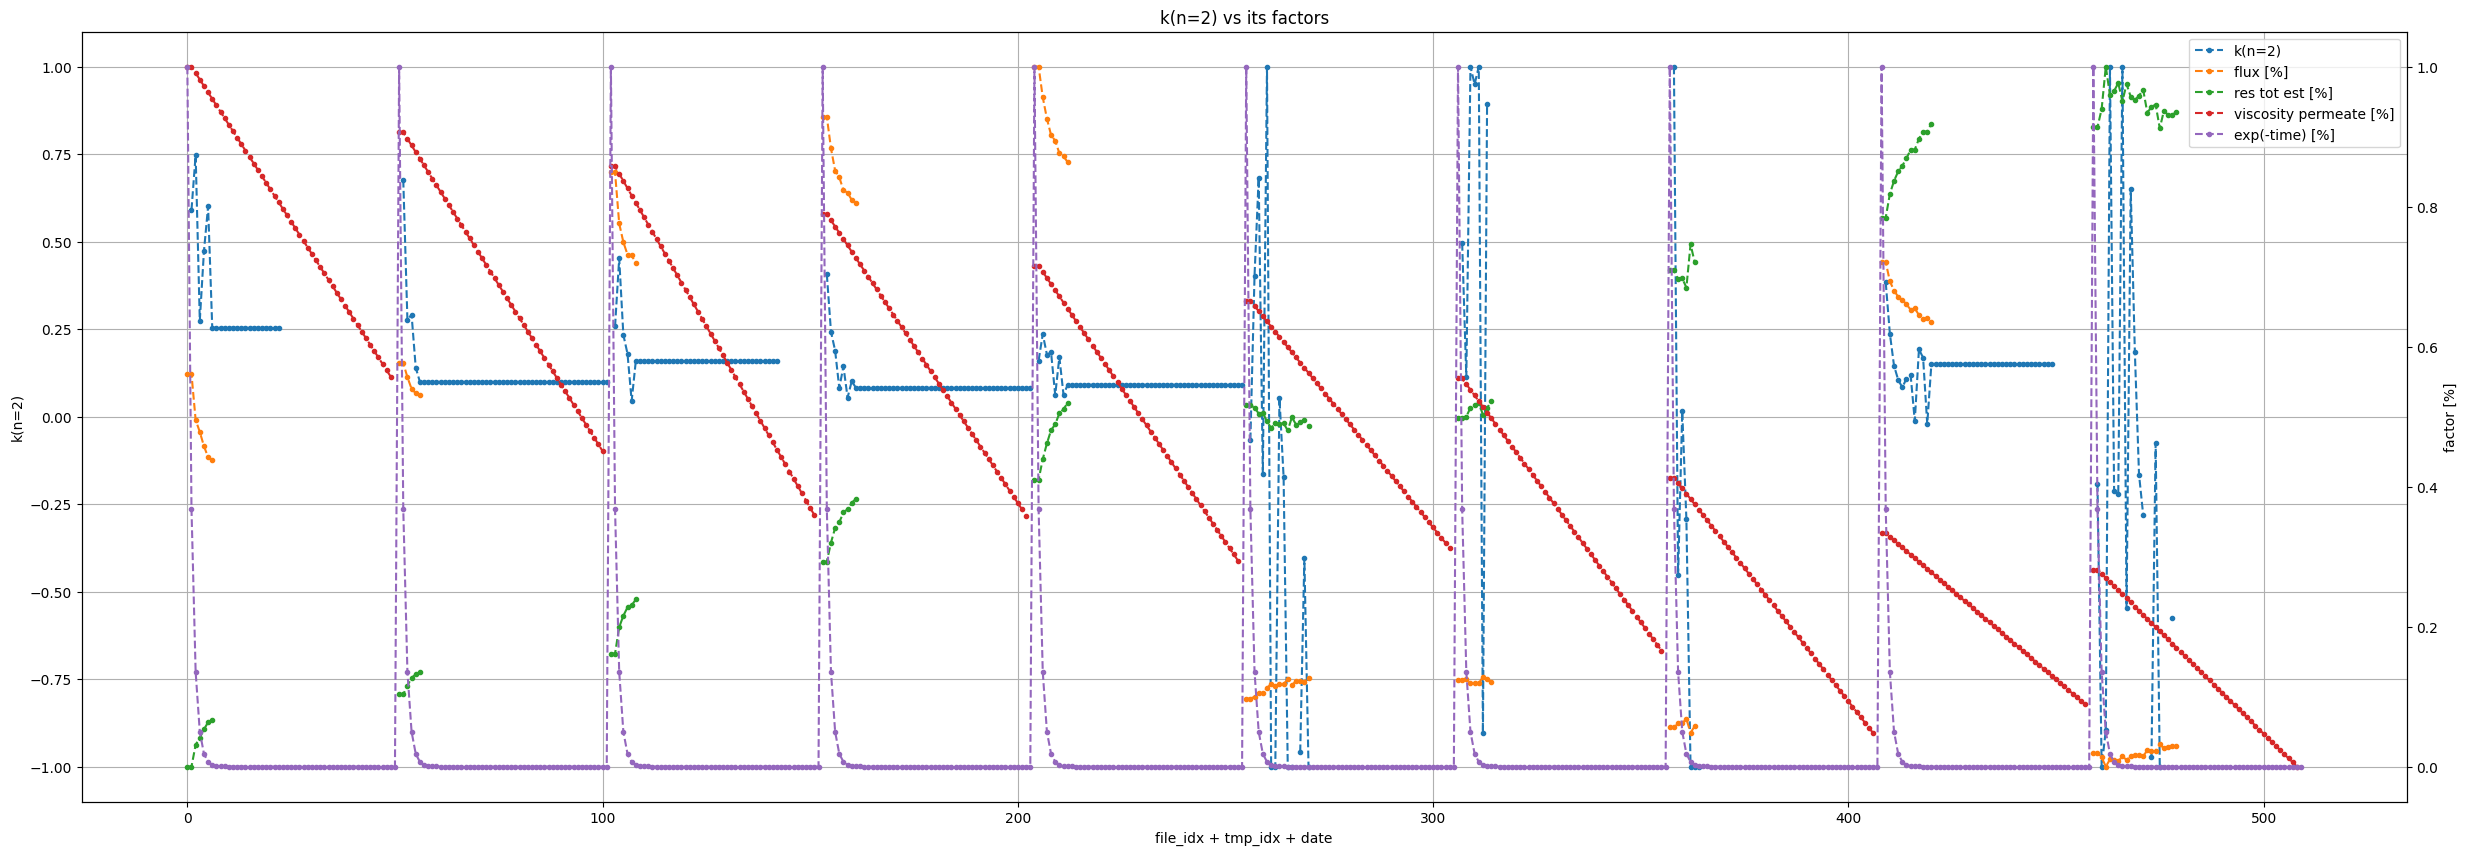

In [19]:
factors = [
    'flux [L/m^2h]', 'res tot est [1/m]', 'viscosity permeate [Pa s]', 'exp(-time) [m]' #, 'retentate concentration est [g/L]', 'permeate concentration est [g/L]'
]
y_ax_lbl = ['k(n=2)', 'factor [%]']
title    = 'k(n=2) vs its factors over time'
#plot_time_series_1_axis(x=df[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=df['index'], y_ax_lbl=y_ax_lbl, title=title, x_format=x_format[TIME_IDX])
# for file_idx in distinct(df['file_idx']) :
#     for tmp_idx in distinct(df['tmp_idx']) :
#         cur_df = df[(df['file_idx'] == file_idx) & (df['tmp_idx'] == tmp_idx)]
y_dict, lbls, y_ax_lbl, title = get_y_dict_min_max_cols(df, 'k(n=2)', factors)
#df['sigmoid TMP est [%]'] = df['TMP est [%]'].apply(lambda x : sigmoid(x))
#y_dict['sigmoid TMP est [%]'] = df['sigmoid TMP est [%]']
y_dict['k(n=2)']            = df['k(n=2)']
#y_dict['k(n=2) smooth 0.1'] = df['k(n=2) smooth 0.1']
plot_time_series_2_axis(x=df['index'], y_series=y_dict, x_ax_lbl='file_idx + tmp_idx + date', y_ax_lbl=y_ax_lbl, title=title, x_format=None, secondary_y=lbls, loc='upper right', figsize=(30,10))

In [20]:
df_frcst = df[df['is forecast'] == 1]
df_real  = df[(df['is forecast'] == 0)]
df_init = None
df_est = df
if INITIAL_ADDED :
    df_init = df_real[df_real['is initial'] == 1]
    df_real = df_real[df_real['is initial'] == 0]
    df_est  = df_est[df_est['is initial'] == 0]

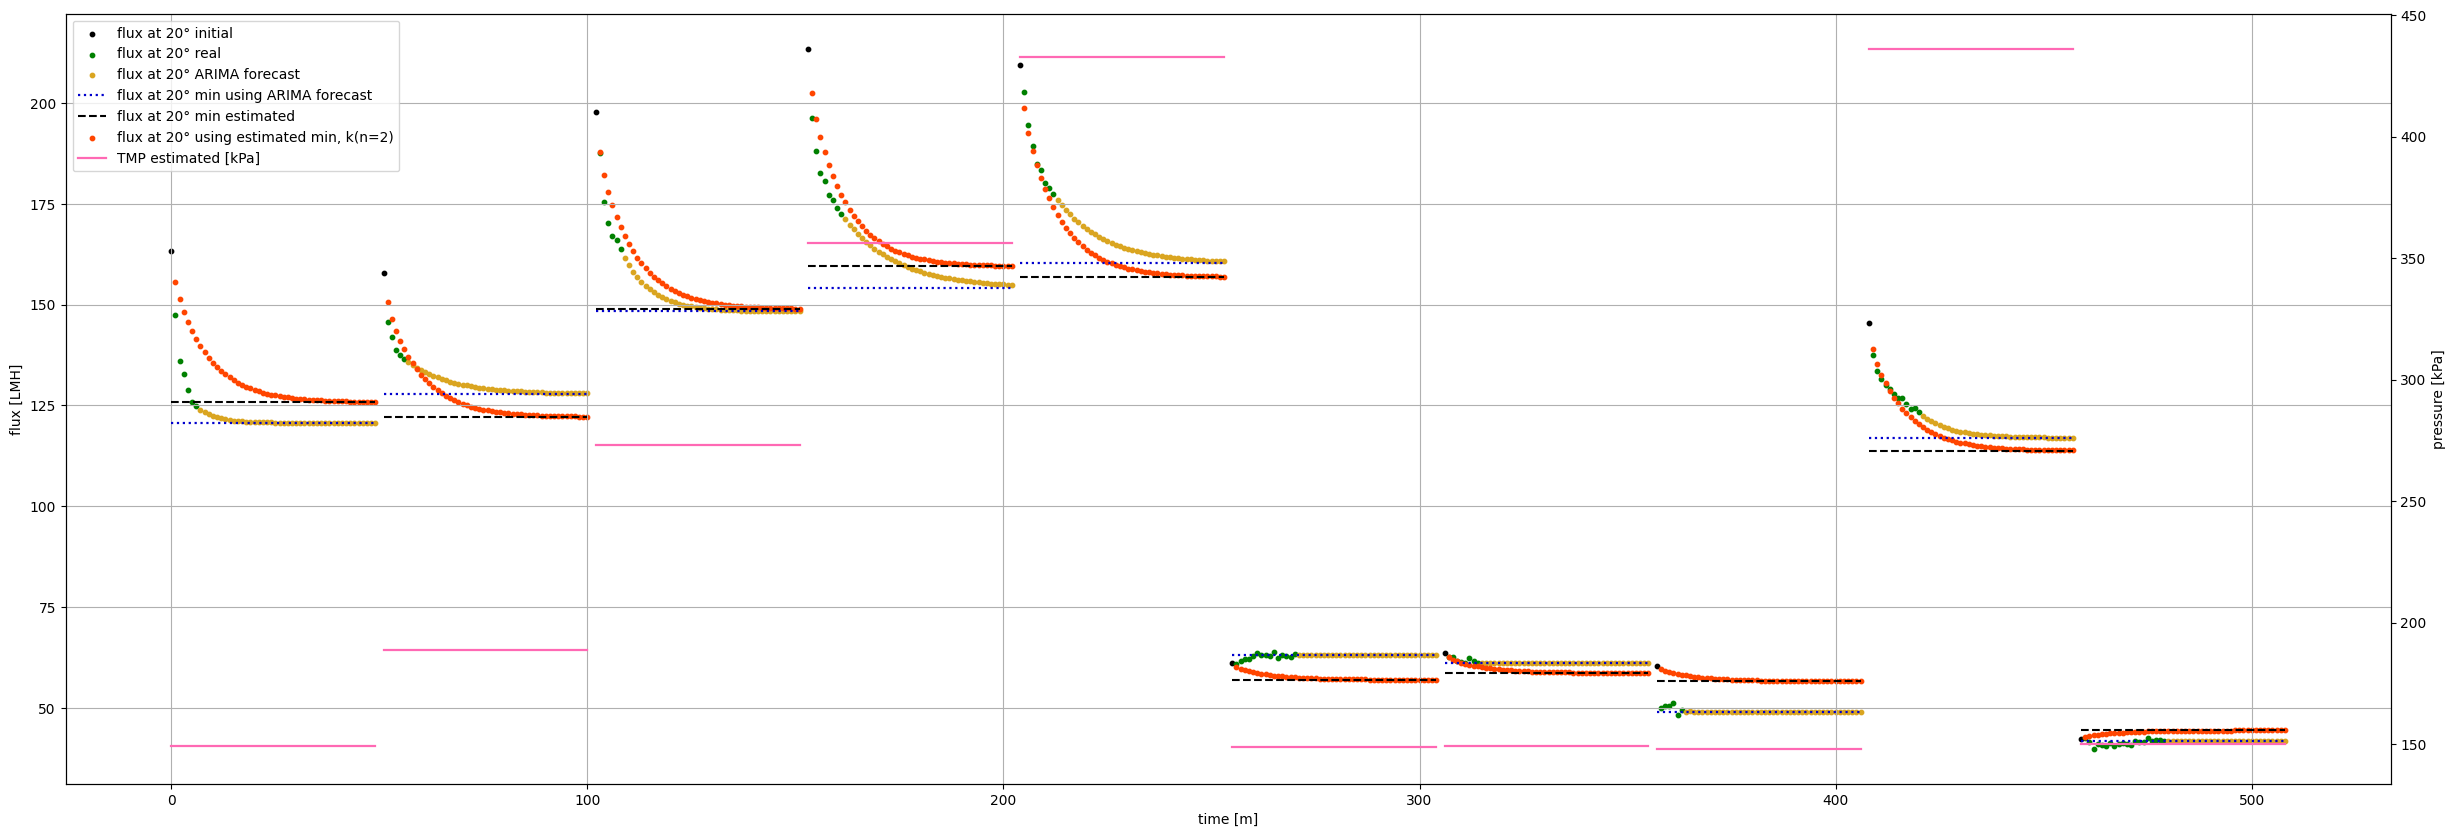

In [29]:
flux = 'flux at 20° [L/m^2h]'
flux_est_0  = f'flux est with k(n=2)-0'
flux_est_1  = f'flux est with k(n=2)-1'
# plot_time_series_1_axis(x=df_real['index'],  y_series={'flux real'    : df_real[flux]},            x_ax_lbl=df_real['index'],  y_ax_lbl=None,            title=None,                           color=['green'])
# plot_time_series_1_axis(x=df_frcst['index'], y_series={'flux forecast': df_frcst[flux]},           x_ax_lbl=df_frcst['index'], y_ax_lbl=None,            title=None,                           color=['gold'],  figsize=None)
# plot_time_series_1_axis(x=df['index'],       y_series={'flux pred using k(n=2)': df['flux pred']}, x_ax_lbl=df['index'],       y_ax_lbl='flux [L/m^2h]', title='Flux estimation given k(n=2)', color=['red'], figsize=None)

fig, ax1 = plot.subplots(figsize=(30,10))
ax2 = ax1.twinx()

if INITIAL_ADDED :
    ax1.scatter(df_init['index'],  df_init[flux],  color='black', marker='o', s=10, label=f'{FLUX_USED} initial')
ax1.scatter(df_real['index'],  df_real[flux],                   color='green', marker='o', s=10, label=f'{FLUX_USED} real')
ax1.scatter(df_frcst['index'], df_frcst[flux],                  color='goldenrod',  marker='o', s=10, label=f'{FLUX_USED} ARIMA forecast')
ax1.plot(   df['index'],       df[FLUX_MIN_COL],                color='mediumblue',  marker='o', markersize=0, lw=1.6, label=f'{FLUX_USED} min using ARIMA forecast', linestyle='dotted')
ax1.plot(   df['index'],       df['flux min pred [L/m^2h]'],    color='black',        marker='o', markersize=0, lw=1.5, label=f'{FLUX_USED} min estimated', linestyle='dashed')
ax1.scatter(df_est['index'],   df_est[flux_est_0],                 color='orangered',   marker='o', s=10, label=f'{FLUX_USED} using estimated min, k(n=2)')
ax2.plot(   df['index'],       df['TMP est [kPa]'],             color='hotpink',   marker='o', markersize=0, lw=1.6, label='TMP estimated [kPa]')

ax1.set_xlabel("time [m]")
ax1.set_ylabel("flux [LMH]")
ax2.set_ylabel("pressure [kPa]")

ax1.grid()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')

In [22]:
y_col = FLUX_COL
y = df[FLUX_COL].dropna()
y_pred = df[flux_est_0].dropna()
print(get_error_stats(y, y_pred, y_col))
print()
compute_error_metrics(y, y_pred)
print()

        flux at 20° [L/m^2h]  absolute error  relative error  squared error
min                39.858642        0.000000        0.000000       0.000000
median            120.709745        3.946139        0.036519      15.572038
mean              107.800250        4.338286        0.052034      26.567662
max               213.449219       17.539193        0.210011     307.623292
var              2251.716646        7.762458        0.002039    1403.108045
std                47.452256        2.786119        0.045154      37.458084

Error metrics:
R^2      0.9882
RMSE     5.1544
MAE      4.3383
MedAE    3.9461
maxAE   17.5392
MAPE     0.0520
maxAPE   0.2100


{'R^2': 0.9881775072959805,
 'RMSE': 5.15438277733224,
 'MAE': 4.338286410689659,
 'MedAE': 3.946138738242155,
 'maxAE': 17.539193018716446,
 'MAPE': 0.052034220154125135,
 'maxAPE': 0.21001140462656218}